## Title: Convolutional Neural Network (CNN) - Part II
## Author: Tengku Muhammad Hanis Mokhtar
## Date: May16, 2024

* Adding layer of data augmentation to CNN workflows

### Load the required packages 
kaggle already have this packages, so no need for the installation

In [1]:
library(keras) 

### Specify the path

In [2]:
train_dir <- "../input/skin-cancer/Data/train"
validation_dir <- "../input/skin-cancer/Data/validation"
test_dir <- "../input/skin-cancer/Data/test"

train_benign_dir <- file.path(train_dir, "benign")
train_malignant_dir <- file.path(train_dir, "malignant")

validation_benign_dir <- file.path(validation_dir, "benign")
validation_malignant_dir <- file.path(validation_dir, "malignant")

test_benign_dir <- file.path(test_dir, "benign")
test_malignant_dir <- file.path(test_dir, "malignant")

### Check the number of samples 

In [3]:
num_train_benign <- length(list.files(train_benign_dir))
num_train_malignant <- length(list.files(train_malignant_dir))

num_validation_benign <- length(list.files(validation_benign_dir))
num_validation_malignant <- length(list.files(validation_malignant_dir))

num_test_benign <- length(list.files(test_benign_dir))
num_test_malignant <- length(list.files(test_malignant_dir))

total_train <- num_train_benign + num_train_malignant
total_validation <- num_validation_benign + num_validation_malignant
total_test <- num_test_benign + num_test_malignant

paste("Training set:", total_train)
paste("Validation set:", total_validation)
paste("Testing set:", total_test)

[1] "Training set: 700"

[1] "Validation set: 100"

[1] "Testing set: 200"

### Data generator
Data generator allow us to train the data batch by batch

In [4]:
# Data generator
image_gen <- image_data_generator()

# Define batch size and image size
batch_size <- 100
IMG_HEIGHT <- 224  
IMG_WIDTH <- 224

# Data generator for each set
train_data_gen <- flow_images_from_directory(train_dir,
                                             generator = image_gen,
                                             batch_size = batch_size,
                                             target_size = c(IMG_HEIGHT,
                                                             IMG_WIDTH),
                                             class_mode = "binary")

validation_data_gen <- flow_images_from_directory(validation_dir,
                                                  generator = image_gen,
                                                  batch_size = batch_size,
                                                  target_size = c(IMG_HEIGHT,
                                                                  IMG_WIDTH),
                                                  class_mode = "binary")

test_data_gen <- flow_images_from_directory(test_dir,
                                            generator = image_gen,
                                            batch_size = batch_size,
                                            shuffle = FALSE,
                                            target_size = c(IMG_HEIGHT,
                                                            IMG_WIDTH),
                                            class_mode = "binary")


## Data augmentation layer

In [5]:
data_augmentation <- 
  keras_model_sequential() %>% 
  layer_random_flip("horizontal") %>% 
  layer_random_rotation(0.2)

### Deep learning layers


In [6]:
# DL layers
inputs <- layer_input(shape = c(224, 224, 3))

outputs <- inputs %>%
  data_augmentation() %>%  
  layer_rescaling(1 / 255) %>%
  layer_conv_2d(filters = 32, kernel_size = 3, activation = "relu") %>%
  layer_max_pooling_2d(pool_size = 2) %>%
  layer_conv_2d(filters = 64, kernel_size = 3, activation = "relu") %>%
  layer_max_pooling_2d(pool_size = 2) %>%
  layer_conv_2d(filters = 128, kernel_size = 3, activation = "relu") %>%
  layer_max_pooling_2d(pool_size = 2) %>%
  layer_conv_2d(filters = 256, kernel_size = 3, activation = "relu") %>%
  layer_max_pooling_2d(pool_size = 2) %>%
  layer_conv_2d(filters = 256, kernel_size = 3, activation = "relu") %>%
  layer_flatten() %>%
  layer_dropout(0.5) %>%
  layer_dense(1, activation = "sigmoid")

model <- keras_model(inputs, outputs)

# Compile
model %>% compile(loss = "binary_crossentropy",
                  optimizer = "adam",
                  metrics = "accuracy")

### Set up the callbacks

In [7]:
# Callbacks
callbacks <- list(
  callback_model_checkpoint(
    filepath = "dl_scratch_raw_images.h5",
    save_best_only = TRUE,
    monitor = "val_loss"
  ),
  callback_early_stopping(
    monitor = "val_loss",
    min_delta = 0.01,
    patience = 4)
)

### Fit the model

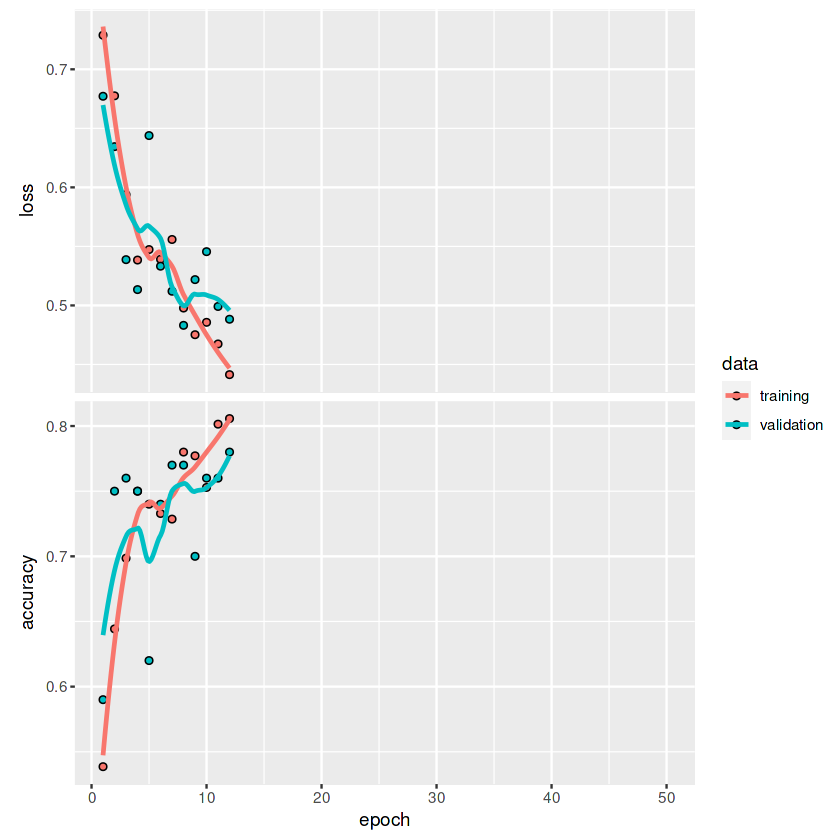

In [8]:
# This will run about ~ 15-20min
history <- model %>% fit(
  train_data_gen,
  epochs = 50,
  validation_data = validation_data_gen,
  callbacks = callbacks
)
plot(history)

### Performance on the testing set

In [9]:
test_model <- load_model_tf("dl_scratch_raw_images.h5")
result <- evaluate(test_model, test_data_gen)
cat(sprintf("Test accuracy: %.3f\n", result["accuracy"])) 

Test accuracy: 0.740
